In [9]:
import scanpy as sc
import scvelo as scv
import cellrank as cr
import pandas as pd
scv.settings.verbosity = 3
scv.settings.set_figure_params('scvelo')
cr.settings.verbosity = 2
import warnings
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# import pyVIA.core as via
import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
from glob import iglob
import scrublet as scr
import anndata
import scanpy.external as sce
import scvelo as scv
#mport omicverse as ov
#import scrublet as scr # requires 'pip install scrublet'
import os
import sklearn
import bbknn
from sklearn.linear_model import LogisticRegression
import matplotlib as mpl
import scipy
import matplotlib.pyplot as plt
import pickle
import diopy

warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

In [4]:
%%time
import os
holder = []
path = './step00-data/00.data/'
files = os.listdir(path)
files

CPU times: user 237 µs, sys: 169 µs, total: 406 µs
Wall time: 222 µs


['GSM6403185_2_DR',
 'GSM6403184_0_WT',
 'GSM6403187_8_DR',
 'GSM6403183_0_WT',
 'GSM6403186_4_DR']

In [5]:
%%time
import os
holder = []
path = './step00-data/00.data/'
files = os.listdir(path)
for file in files:
    file_dir = os.path.join(path,file)
    print("开始处理：",file)
    holder.append(sc.read_10x_mtx(file_dir,var_names= 'gene_symbols',cache=True))
    holder[-1].var_names_make_unique()
    
    ##add metadata
    holder[-1].obs['ID'] = file.split('_')[0]
    holder[-1].obs['Sample'] = file.split('_')[1]
    holder[-1].obs['Tissue'] = file.split('_')[2]

开始处理： GSM6403185_2_DR
开始处理： GSM6403184_0_WT
开始处理： GSM6403187_8_DR
开始处理： GSM6403183_0_WT
开始处理： GSM6403186_4_DR
CPU times: user 1min 34s, sys: 1.89 s, total: 1min 36s
Wall time: 1min 36s


In [6]:
cell_cycle_genes = [x.strip().title() for x in open('./step00-data/regev_lab_cell_cycle_genes.txt')]
s_genes = [x for x in cell_cycle_genes[:43]]
g2m_genes = [x for x in cell_cycle_genes[43:]]

In [10]:
%%time
adata = holder[0].concatenate(holder[1:],join='outer',index_unique=None)
adata.X = adata.X.tocsr()
adata.var_names_make_unique()

CPU times: user 217 ms, sys: 121 ms, total: 338 ms
Wall time: 334 ms


In [11]:
# Filer cells with less than 200 genes expressed
sc.pp.filter_cells(adata, min_genes=200)
# Filer genes expressed in less than 3 cells
sc.pp.filter_genes(adata, min_cells=3)
print('Remaining cells %d'%adata.n_obs)
print('Remaining gene %d'%adata.n_vars)

Remaining cells 69216
Remaining gene 18742


In [12]:
# mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('Mt-')
# ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith('Rps') | adata.var_names.str.startswith('Rpl')
# hemoglobin genes.
adata.var['hb'] = adata.var_names.str.startswith('Hba') | adata.var_names.str.startswith('Hbb')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo', 'hb'], percent_top=None, log1p=False, inplace=True)

In [13]:
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

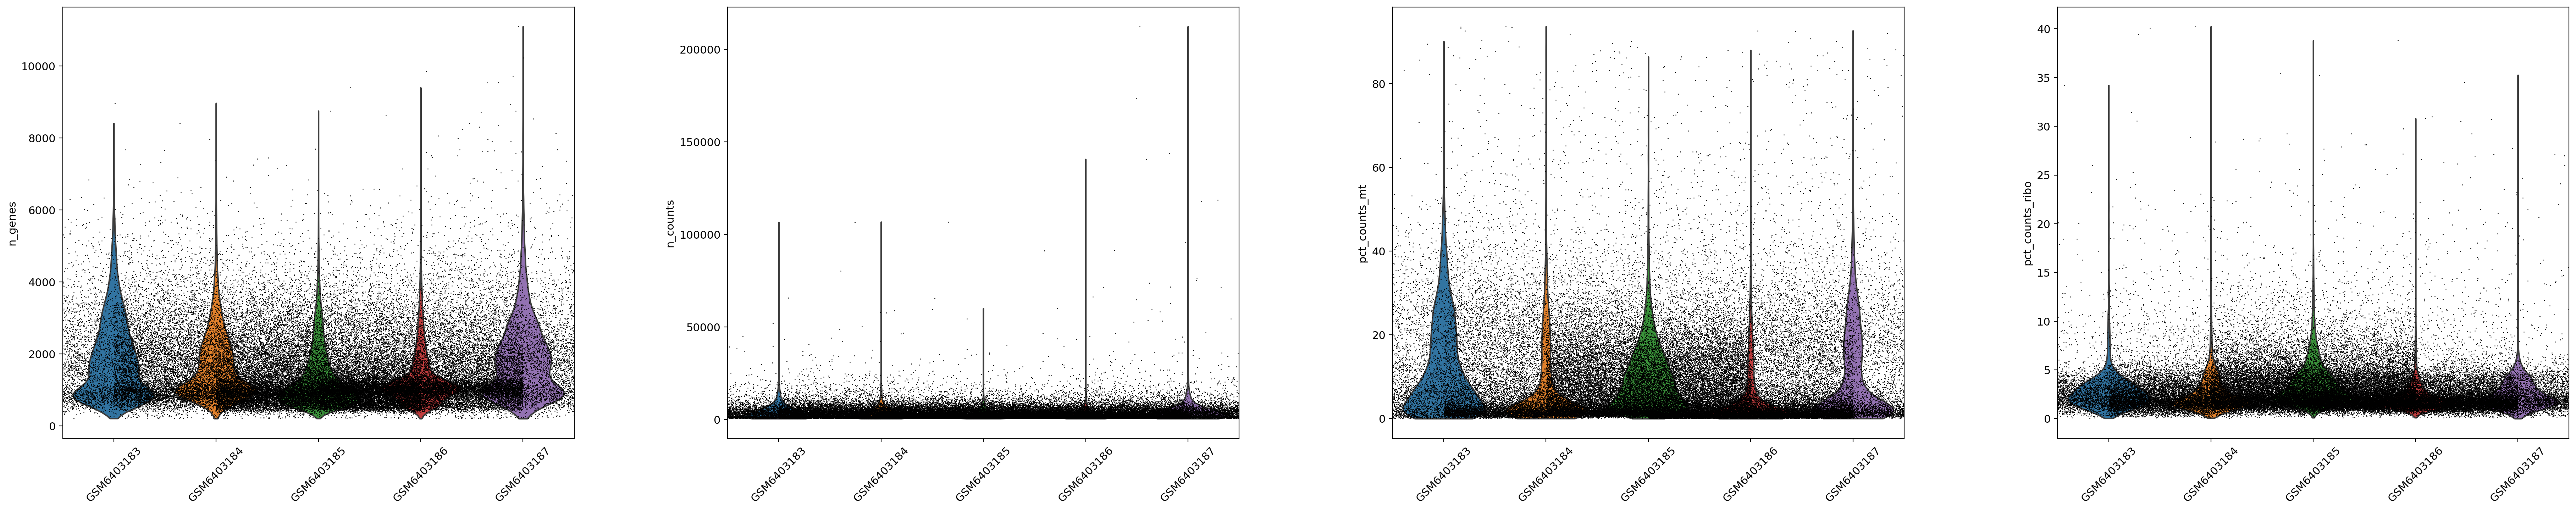

In [14]:
plt.rcParams['figure.figsize']=(8,8)
sc.pl.violin(adata, ['n_genes', 'n_counts', 'pct_counts_mt','pct_counts_ribo',],
             jitter=1, groupby = 'ID', rotation= 45)

In [15]:
upper_lim = np.quantile(adata.obs.n_genes.values,.98)
lower_lim = np.quantile(adata.obs.n_genes.values,.02)
print(f'{lower_lim} to {upper_lim}')


ribo_lim =np.quantile(adata.obs.pct_counts_ribo.values,.02)
ribo_lim =5 if ribo_lim >5 else ribo_lim 
print(ribo_lim)

452.0 to 4294.0
0.6109671652317047


In [16]:
upper_lim = np.quantile(adata.obs.n_genes.values,.98)
lower_lim = np.quantile(adata.obs.n_genes.values,.02)
print(f'{lower_lim} to {upper_lim}')


ribo_lim =np.quantile(adata.obs.pct_counts_ribo.values,.02)
ribo_lim =5 if ribo_lim >5 else ribo_lim 
print(ribo_lim)

452.0 to 4294.0
0.6109671652317047


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.43
Detected doublet rate = 1.6%
Estimated detectable doublet fraction = 16.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 9.7%
Elapsed time: 113.3 seconds


(<Figure size 800x300 with 2 Axes>,
 array([<AxesSubplot: title={'center': 'Observed transcriptomes'}, xlabel='Doublet score', ylabel='Prob. density'>,
        <AxesSubplot: title={'center': 'Simulated doublets'}, xlabel='Doublet score', ylabel='Prob. density'>],
       dtype=object))

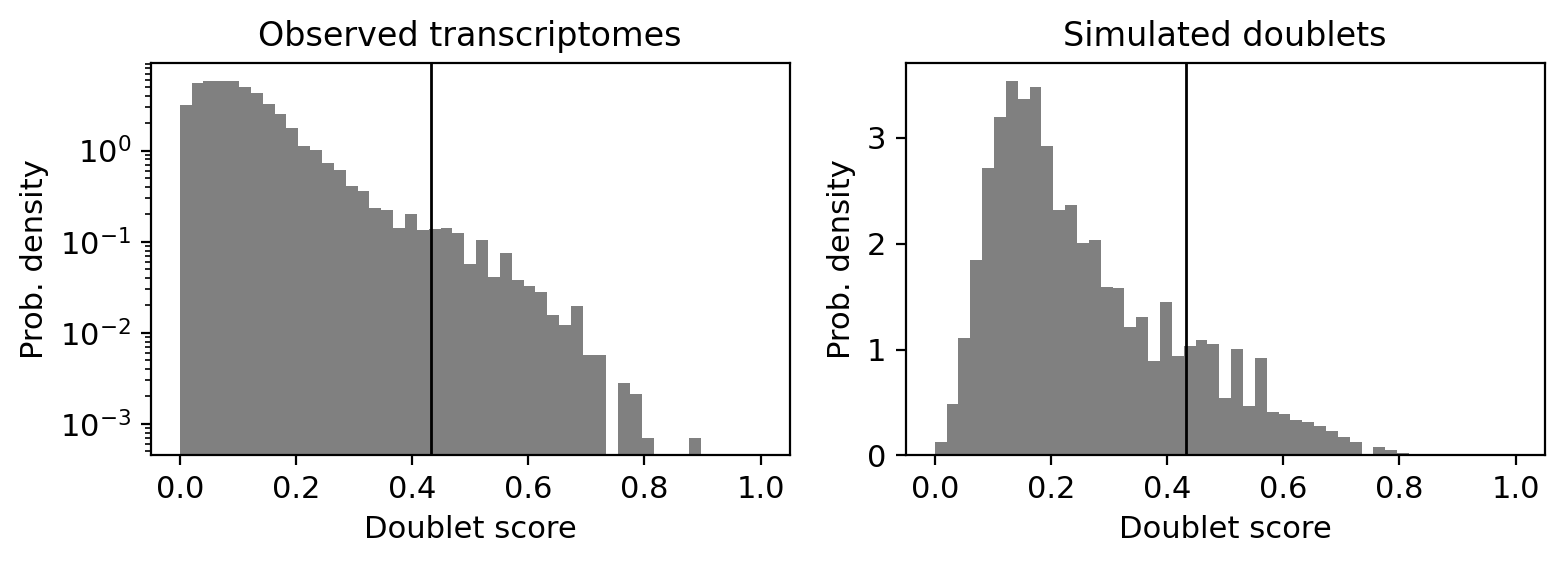

In [17]:
scrub = scr.Scrublet(adata.X)
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()

In [18]:
num_predicted_doublets = sum(adata.obs['predicted_doublets'])
print(f"Predicted {num_predicted_doublets} doublets")

Predicted 1101 doublets


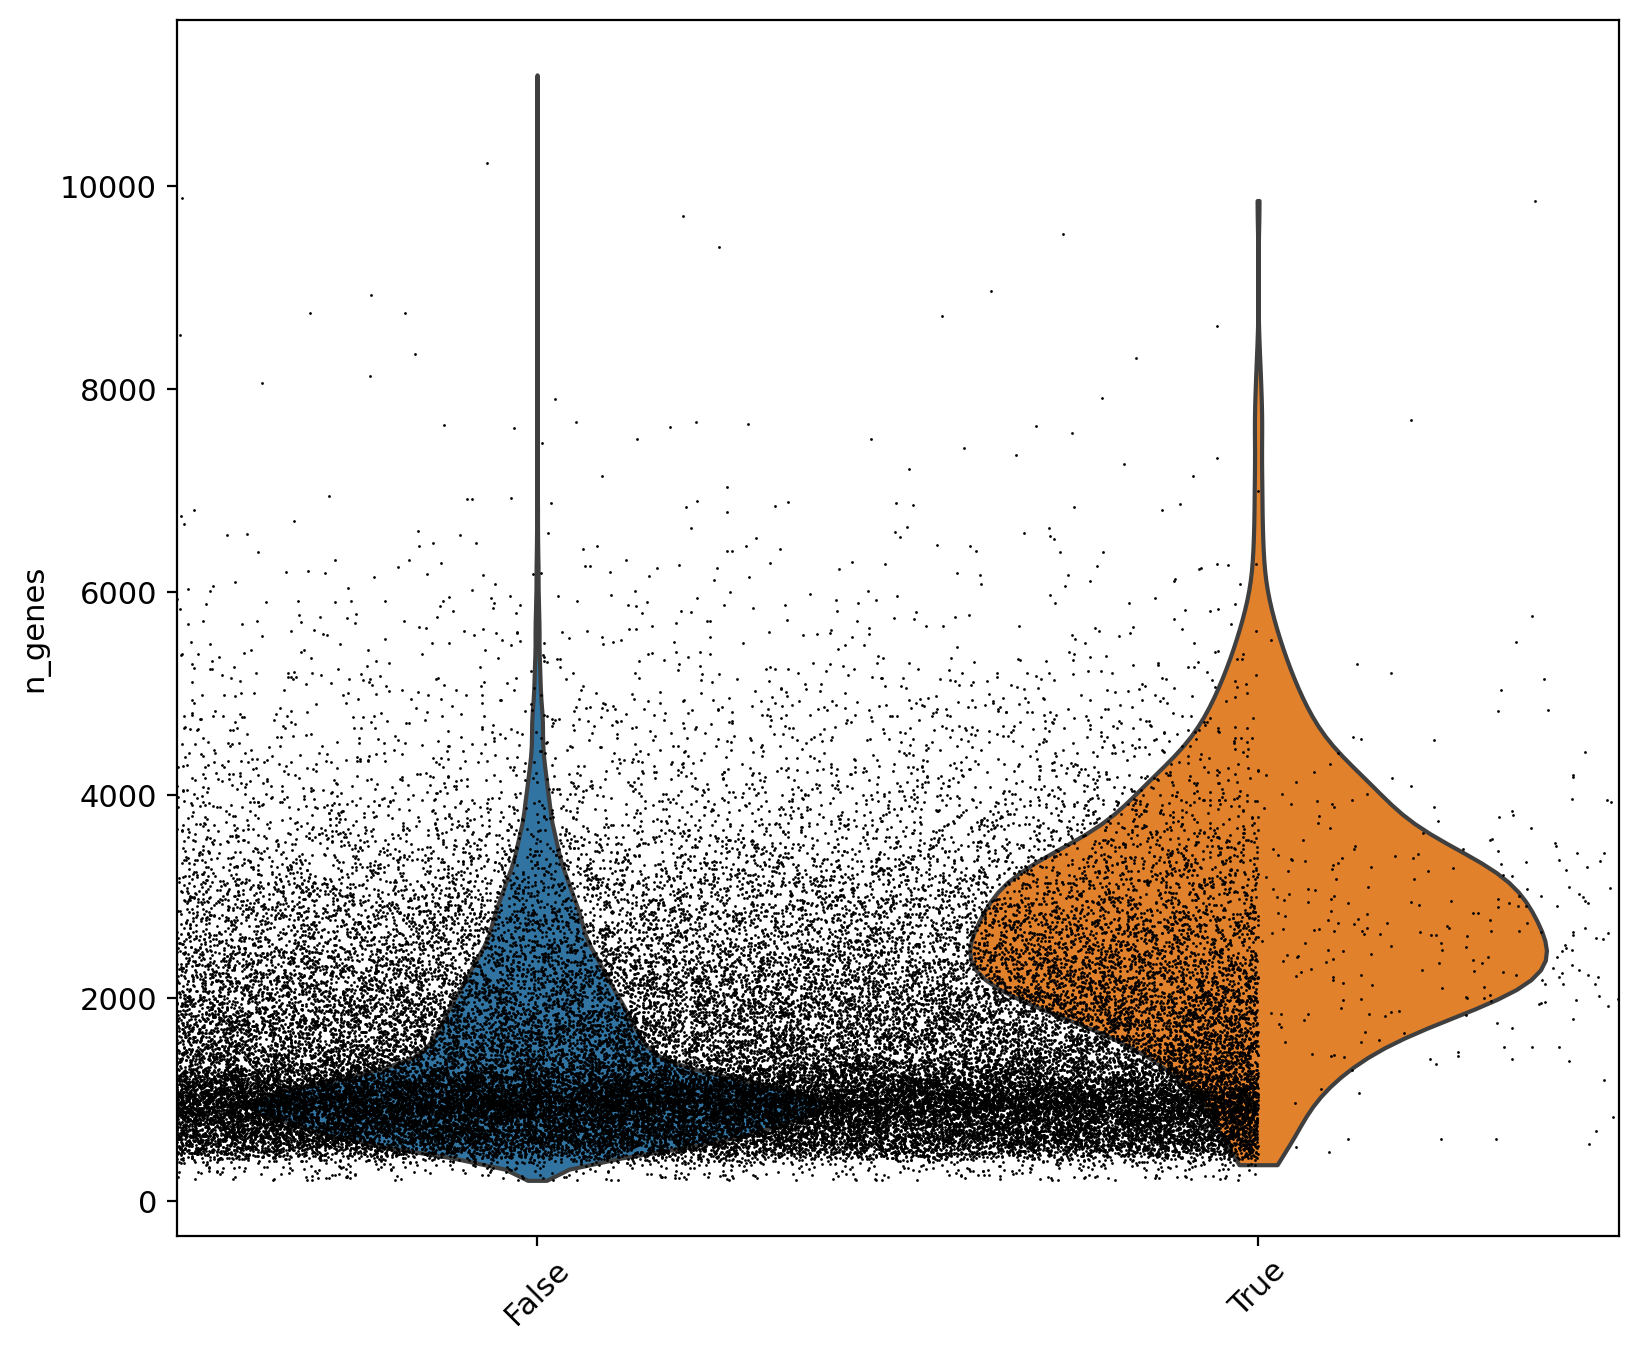

In [19]:
adata.obs['doublet_info'] = adata.obs["predicted_doublets"].astype(str)
sc.pl.violin(adata, 'n_genes',
             jitter=1, groupby = 'doublet_info', rotation=45) 

In [20]:
adata = adata[adata.obs['doublet_info'] == 'False',:]
adata.write_h5ad('./cache/sc_qc.h5ad')

In [21]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

Highly variable genes: 2141


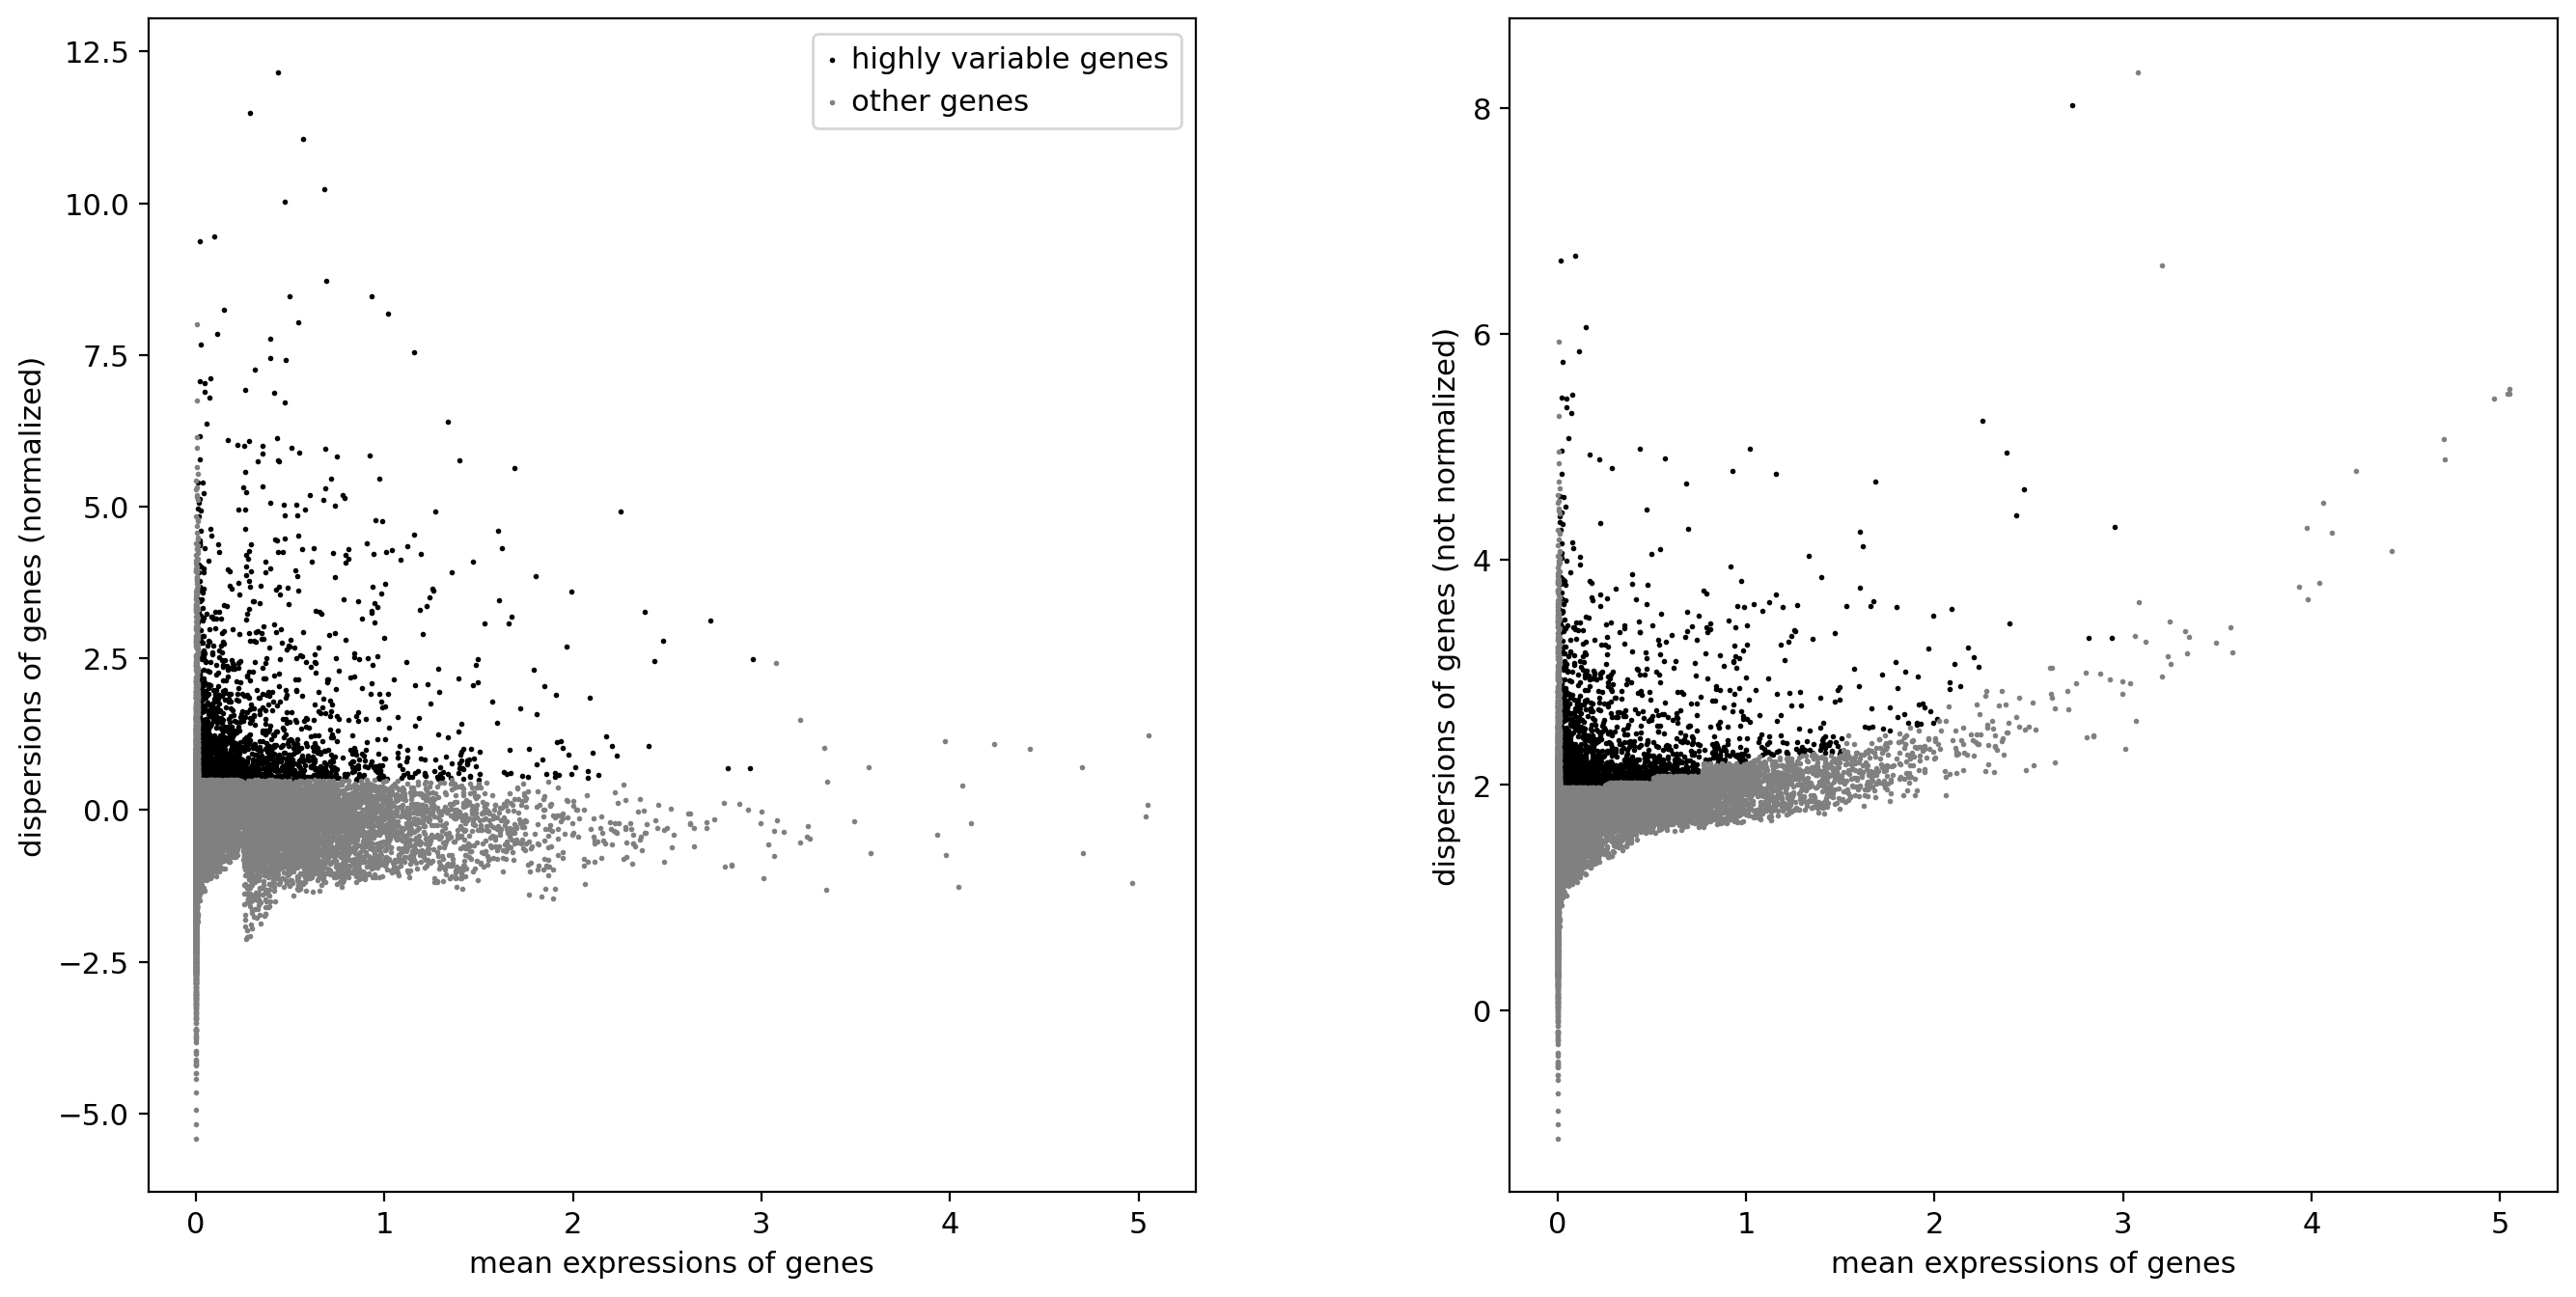

In [22]:
sc.pp.highly_variable_genes(adata, max_mean=3, min_disp=0.5)
print("Highly variable genes: %d"%sum(adata.var.highly_variable))
sc.pl.highly_variable_genes(adata)

In [24]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

In [25]:
sc.pp.regress_out(adata, keys=['n_counts', 'pct_counts_mt', 'S_score', 'G2M_score'], n_jobs=10)#number of jobs for parallel computation
sc.pp.scale(adata, max_value=10)

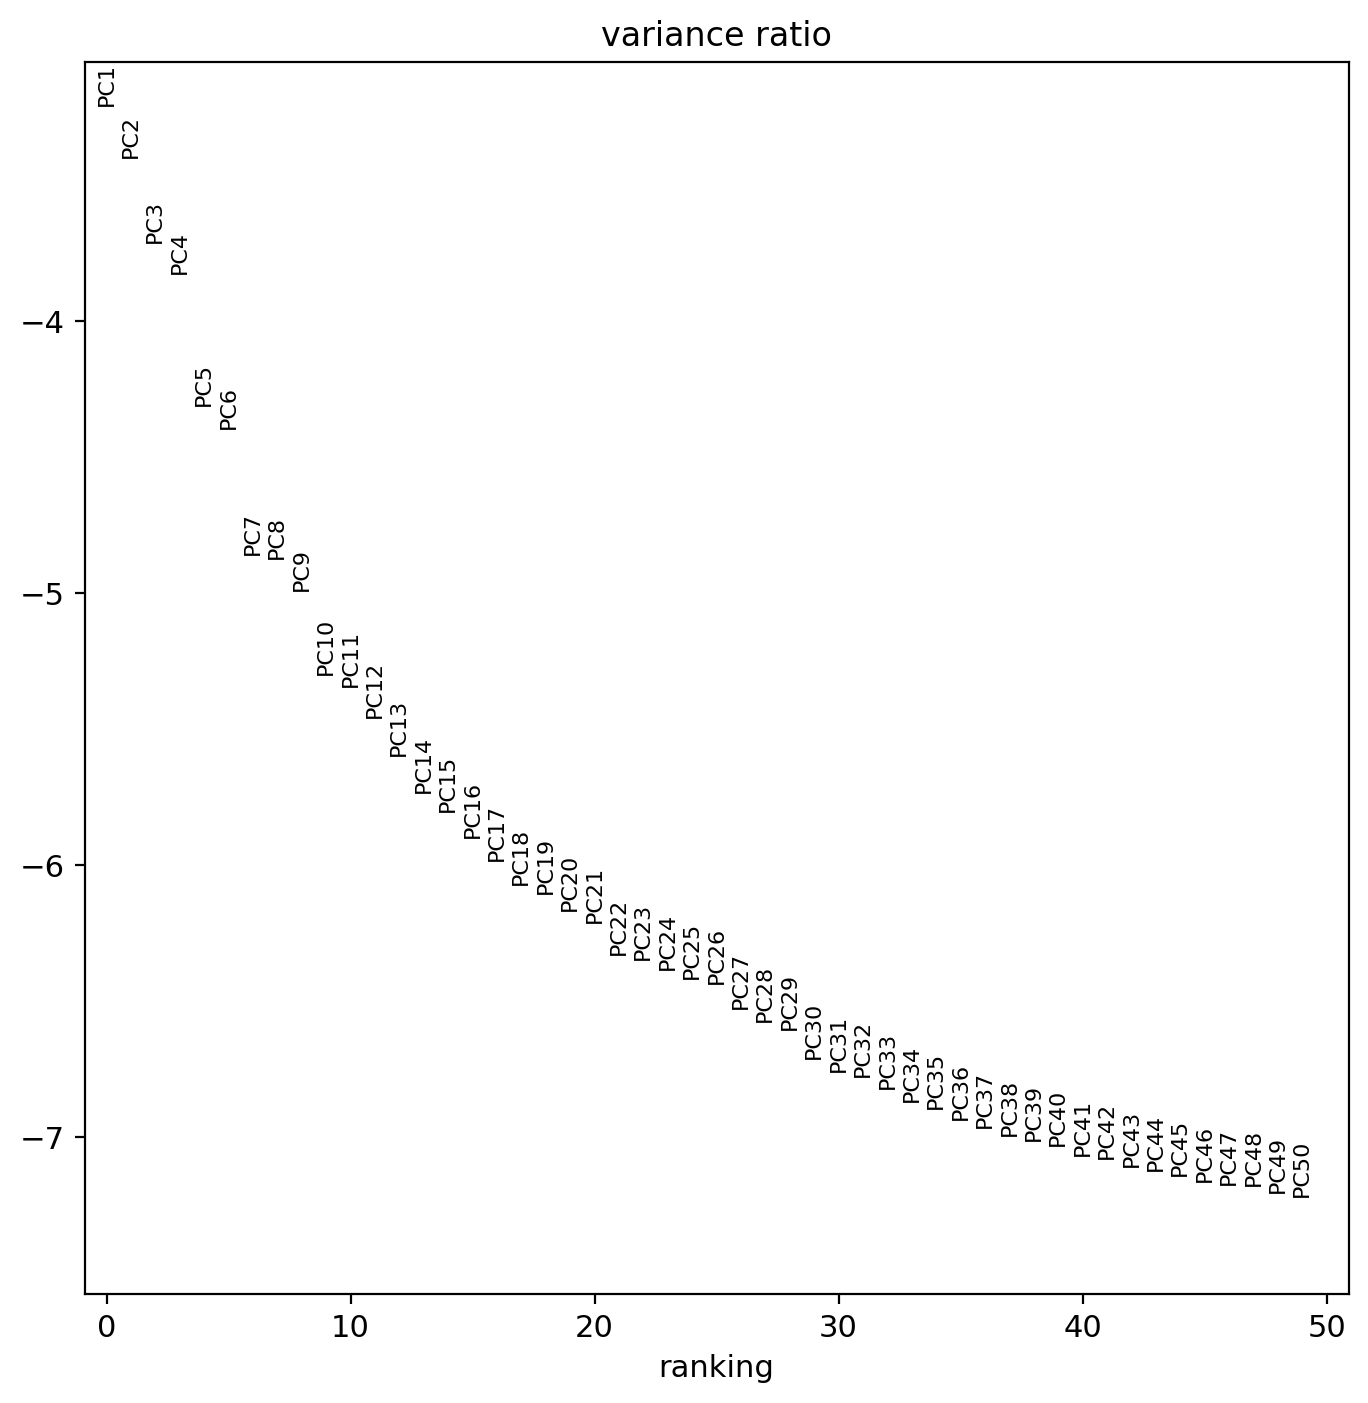

<AxesSubplot: >

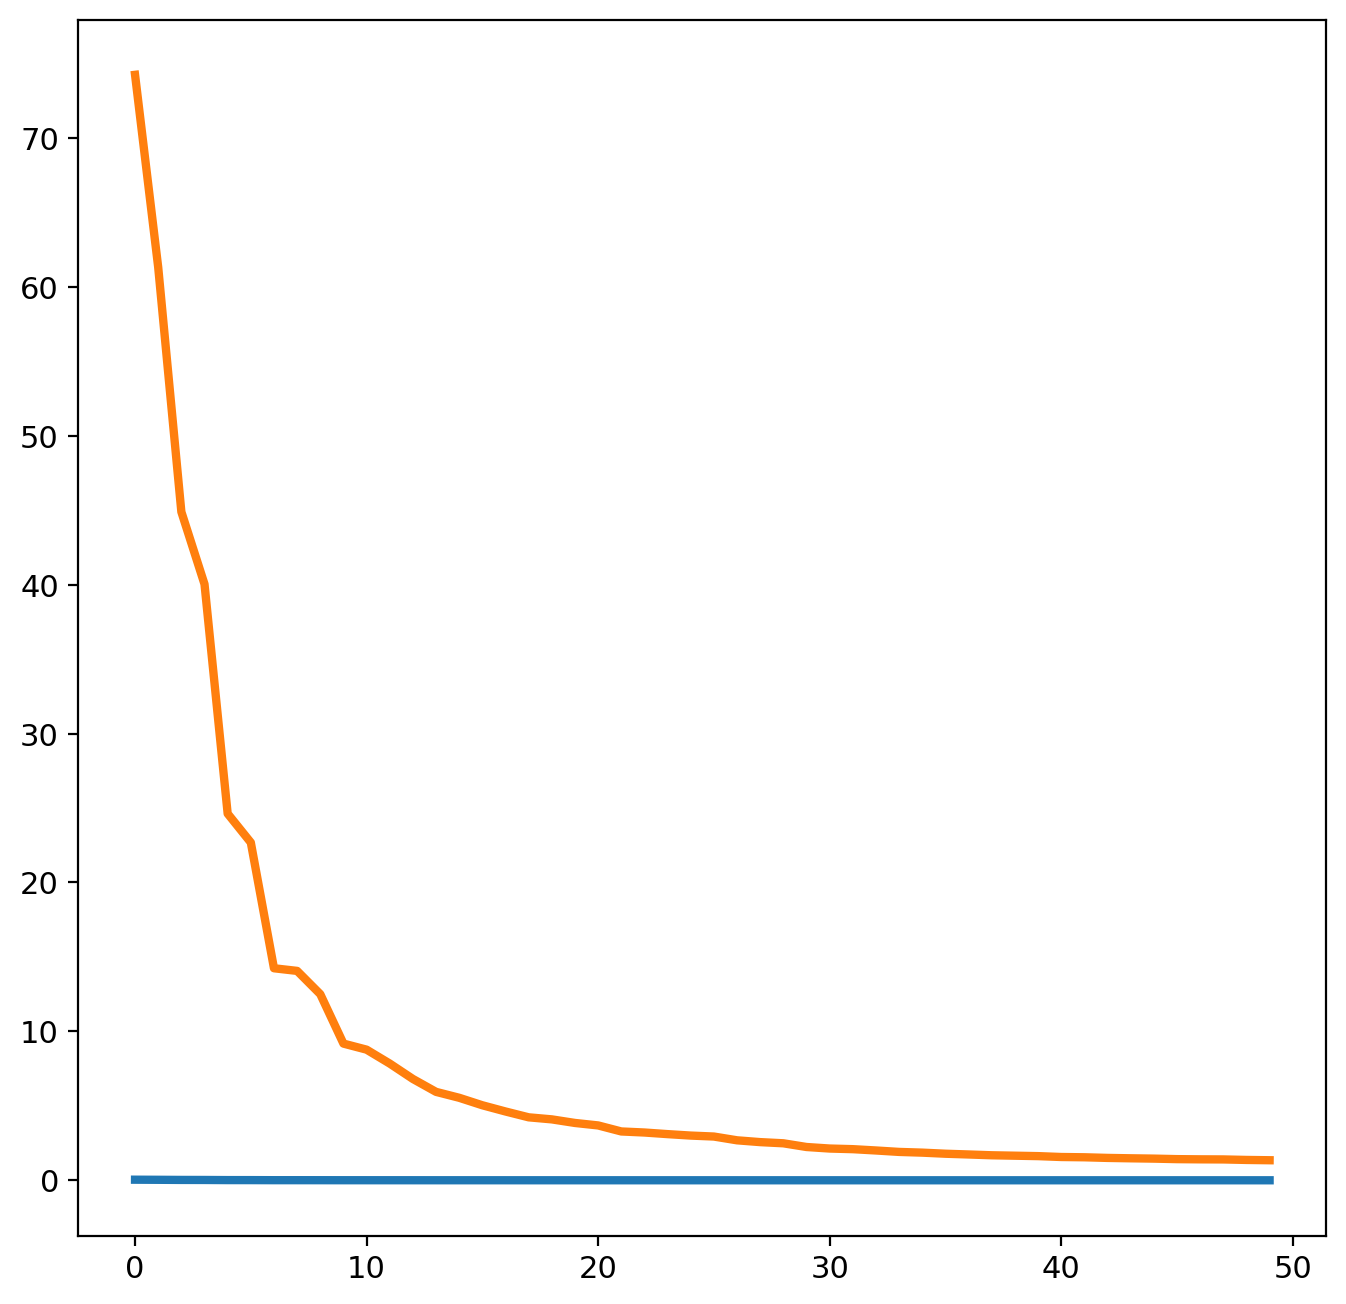

In [26]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True,n_pcs = 50)
sns.lineplot(data = adata.uns['pca']['variance_ratio'],palette= 'tab10',linewidth = 3)
adata.uns['pca']['variance']
sns.lineplot(data =adata.uns['pca']['variance'],palette='tab10',linewidth = 3)

In [ ]:
sce.pp.scanorama_integrate(adata, key='ID',knn=30, sigma=15, approx=True, alpha=0.1)

[[0.         0.34594013 0.39970377 0.79672245 0.47504179]
 [0.         0.         0.87346593 0.51278475 0.38967557]
 [0.         0.         0.         0.61436541 0.59870927]
 [0.         0.         0.         0.         0.81996746]
 [0.         0.         0.         0.         0.        ]]
Processing datasets GSM6403184 <=> GSM6403187
Processing datasets GSM6403183 <=> GSM6403186
Processing datasets GSM6403185 <=> GSM6403183
Processing datasets GSM6403187 <=> GSM6403183
Processing datasets GSM6403187 <=> GSM6403186
Processing datasets GSM6403184 <=> GSM6403183
Processing datasets GSM6403185 <=> GSM6403186


neighbors的数值为：10


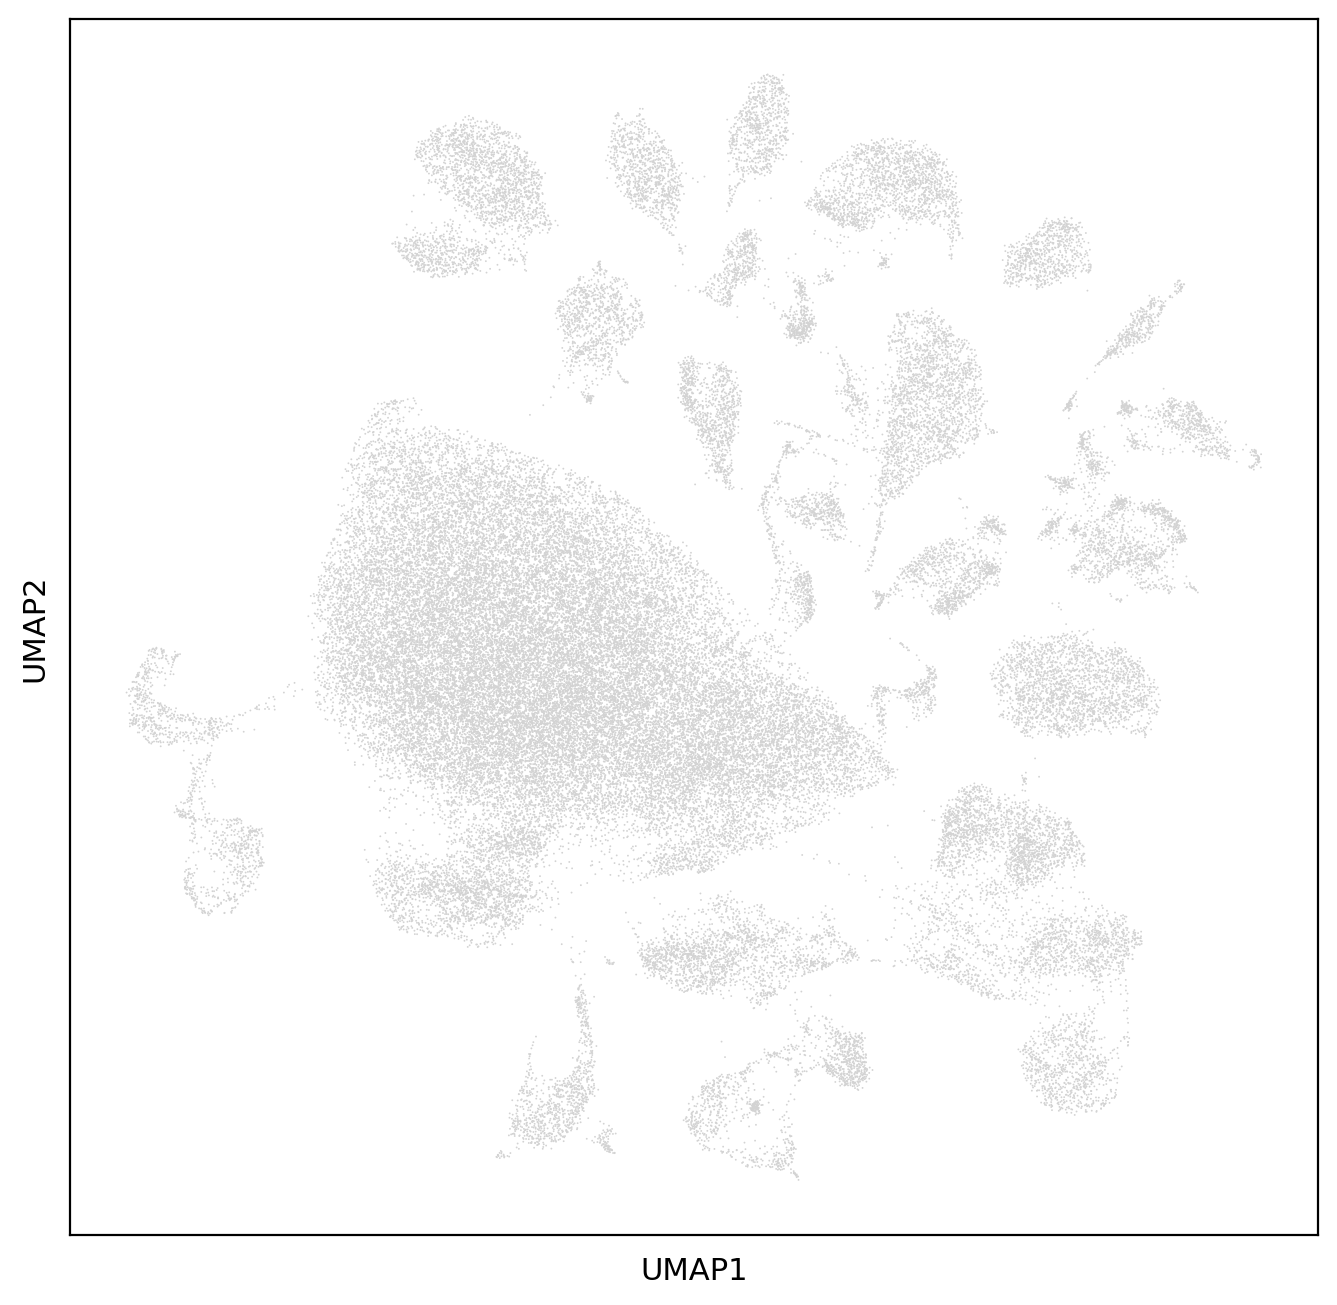

neighbors的数值为：15


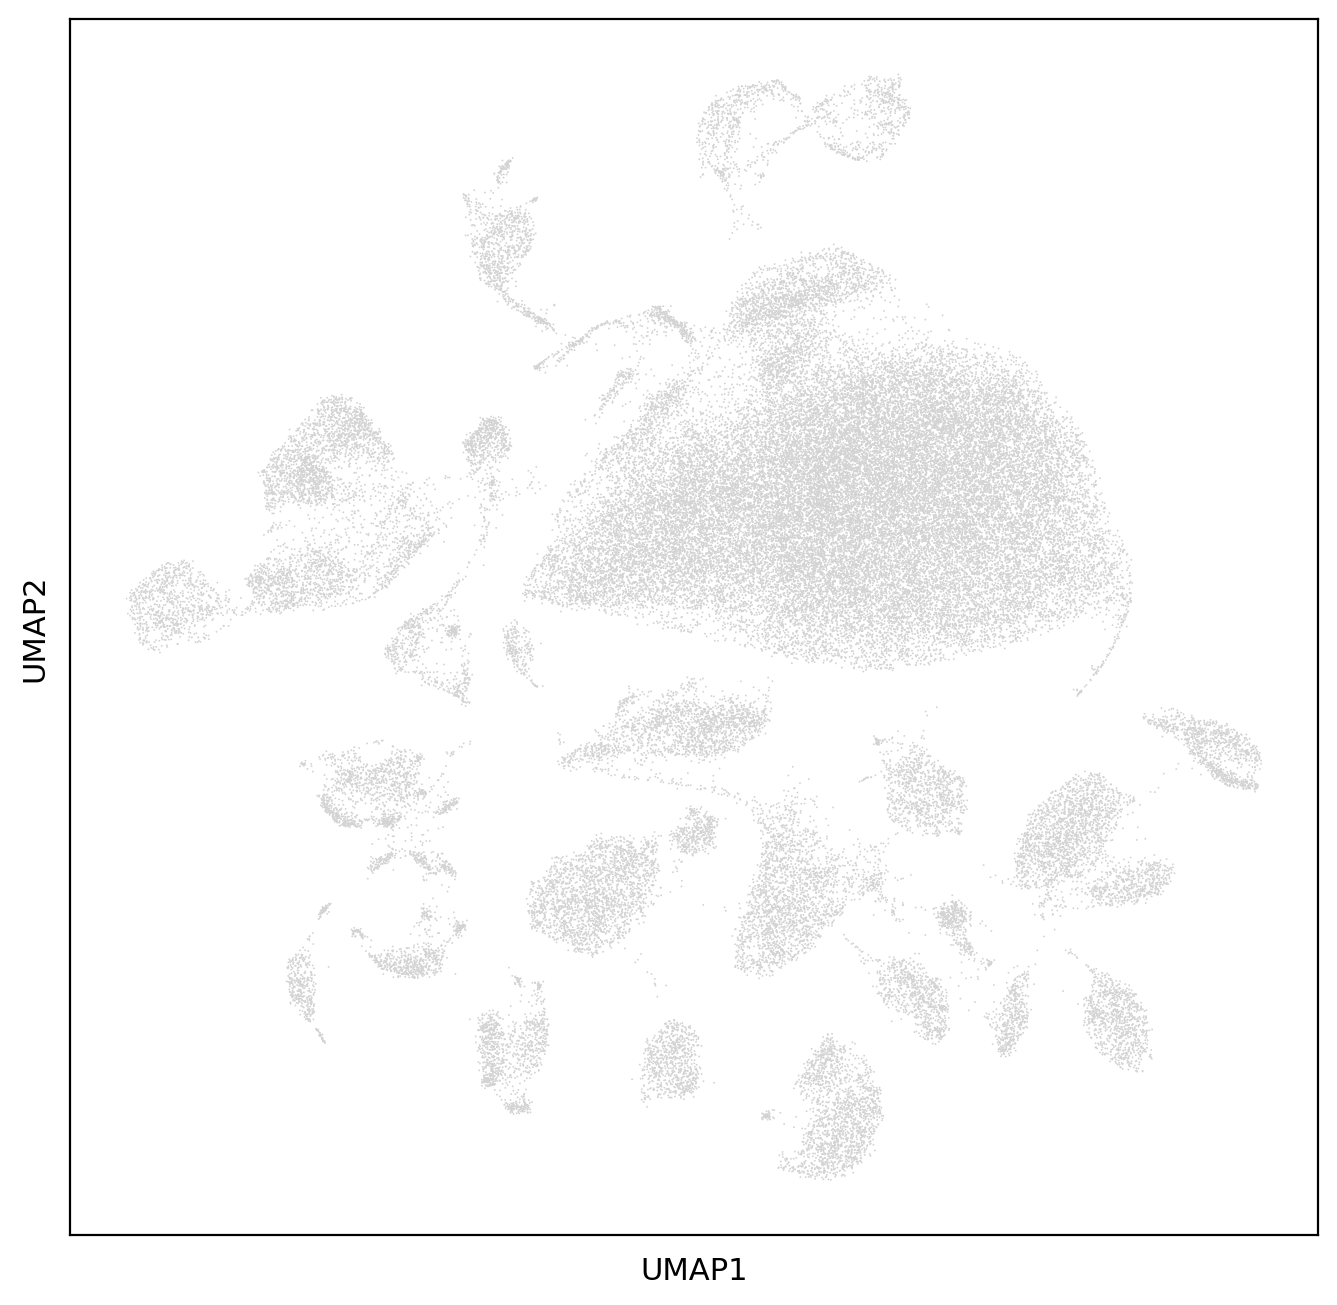

neighbors的数值为：20


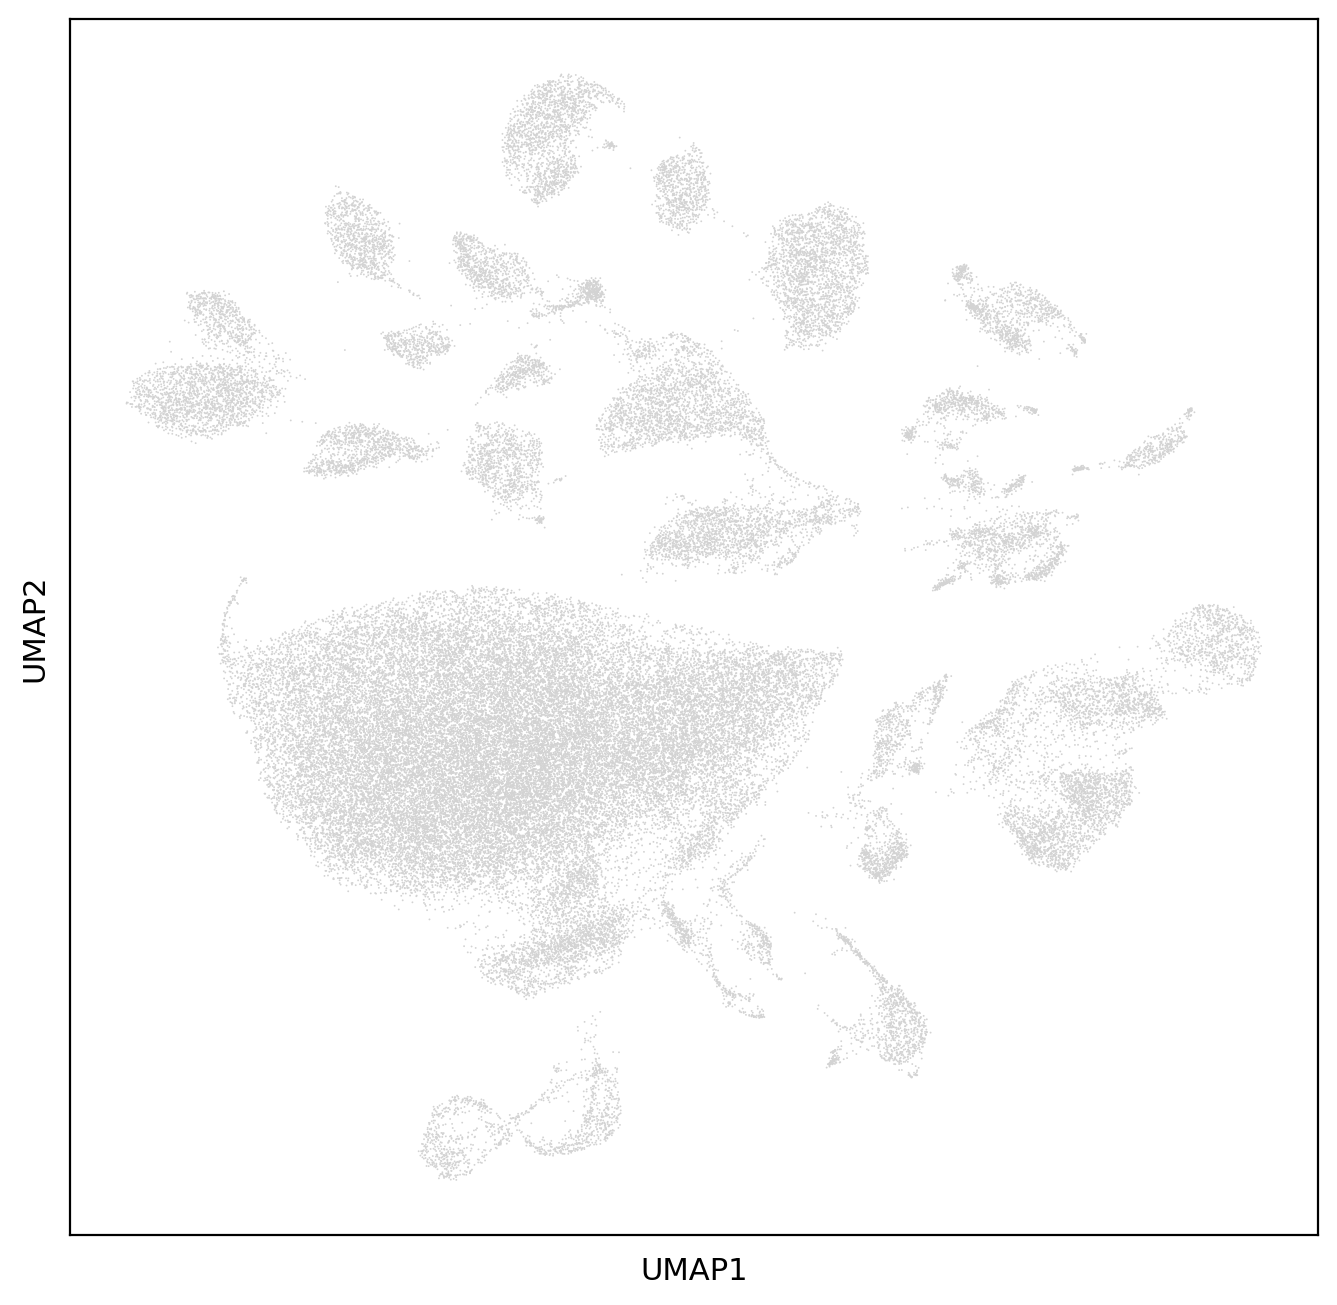

neighbors的数值为：25


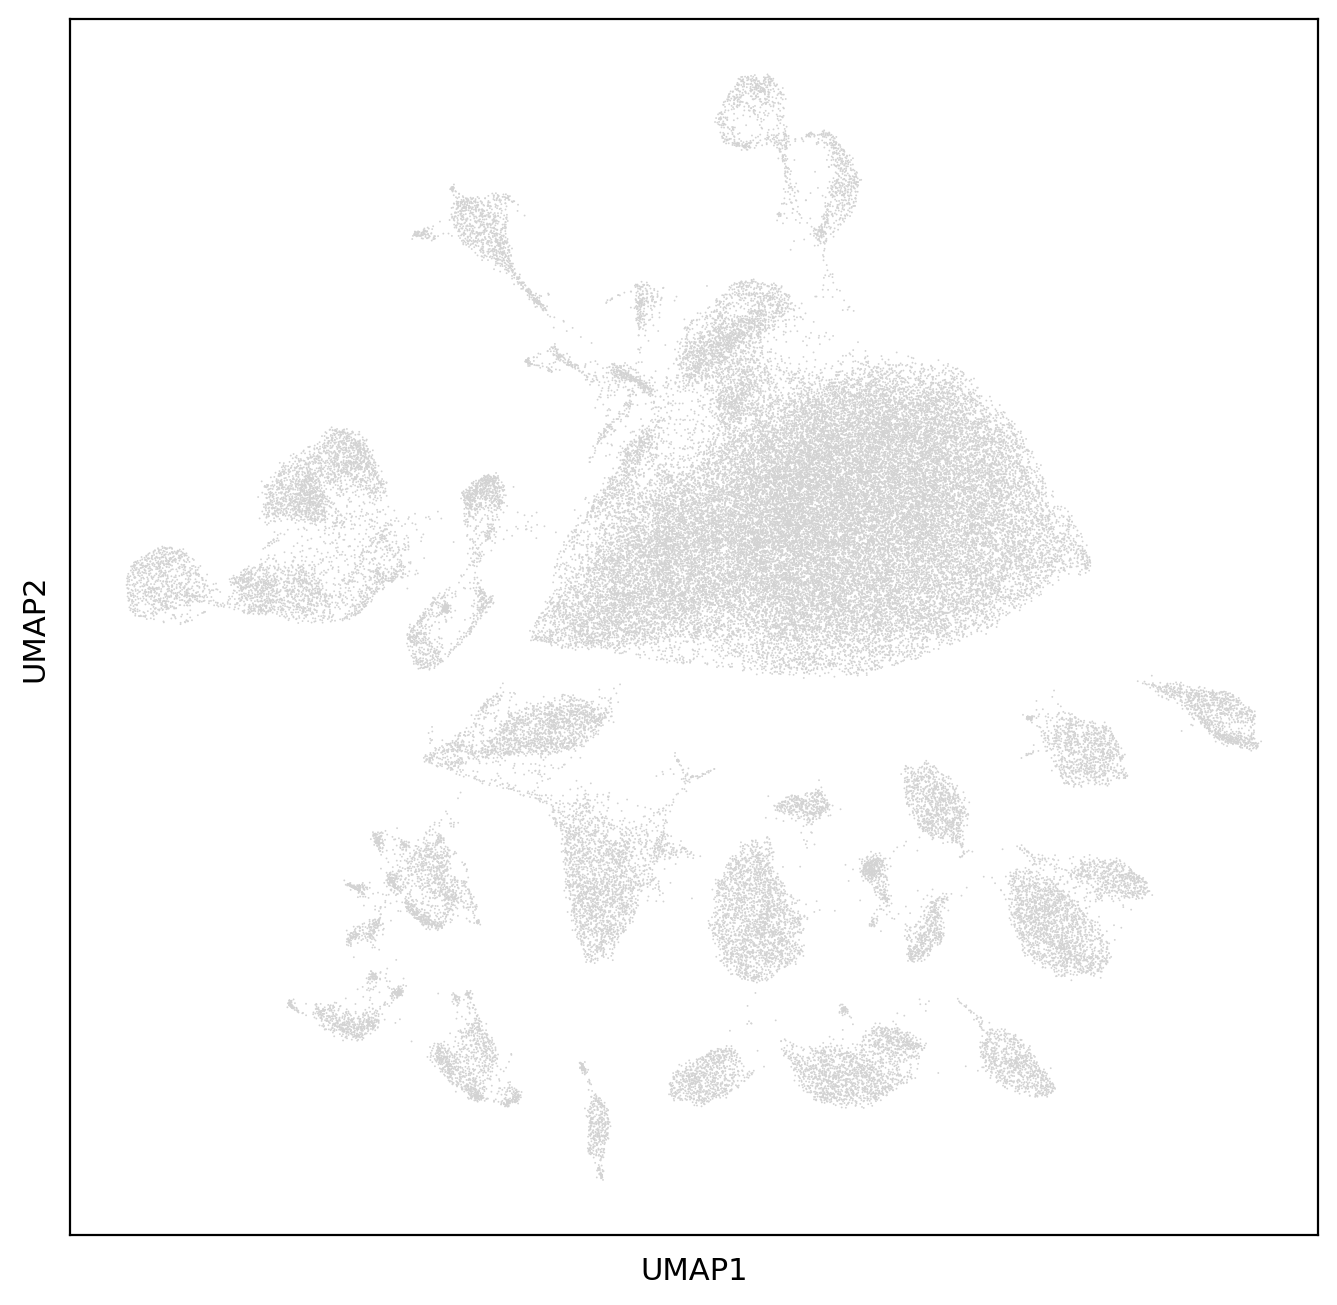

neighbors的数值为：30


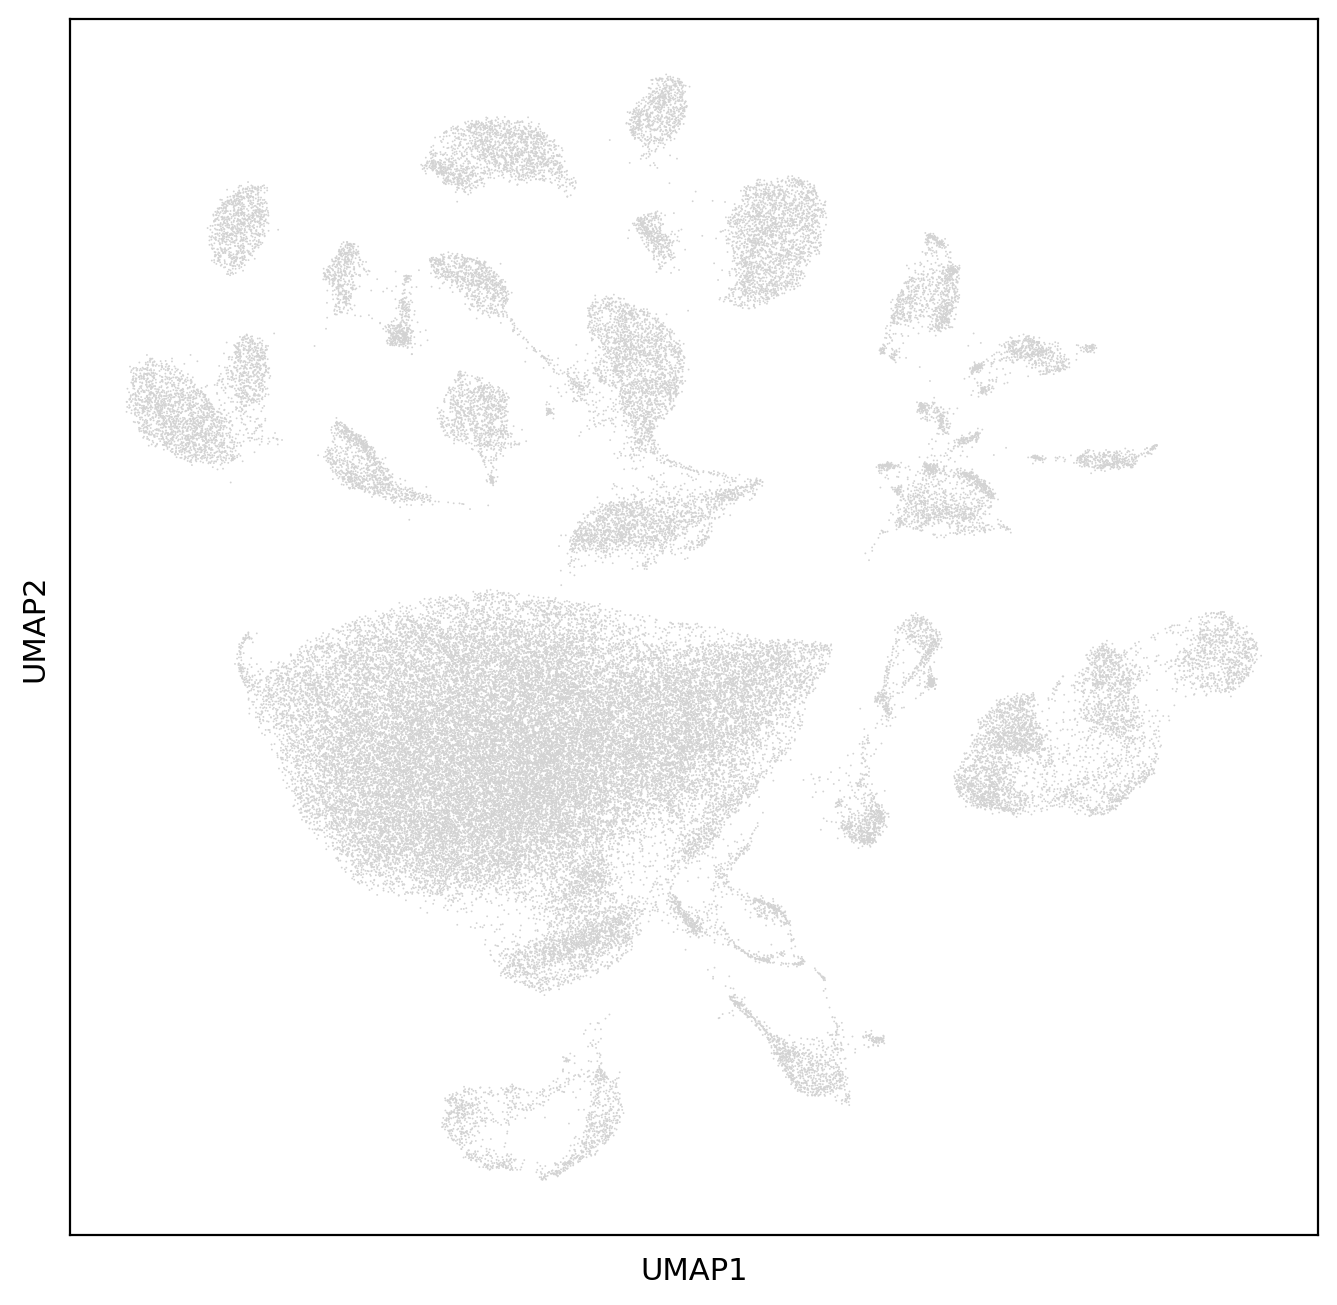

neighbors的数值为：35


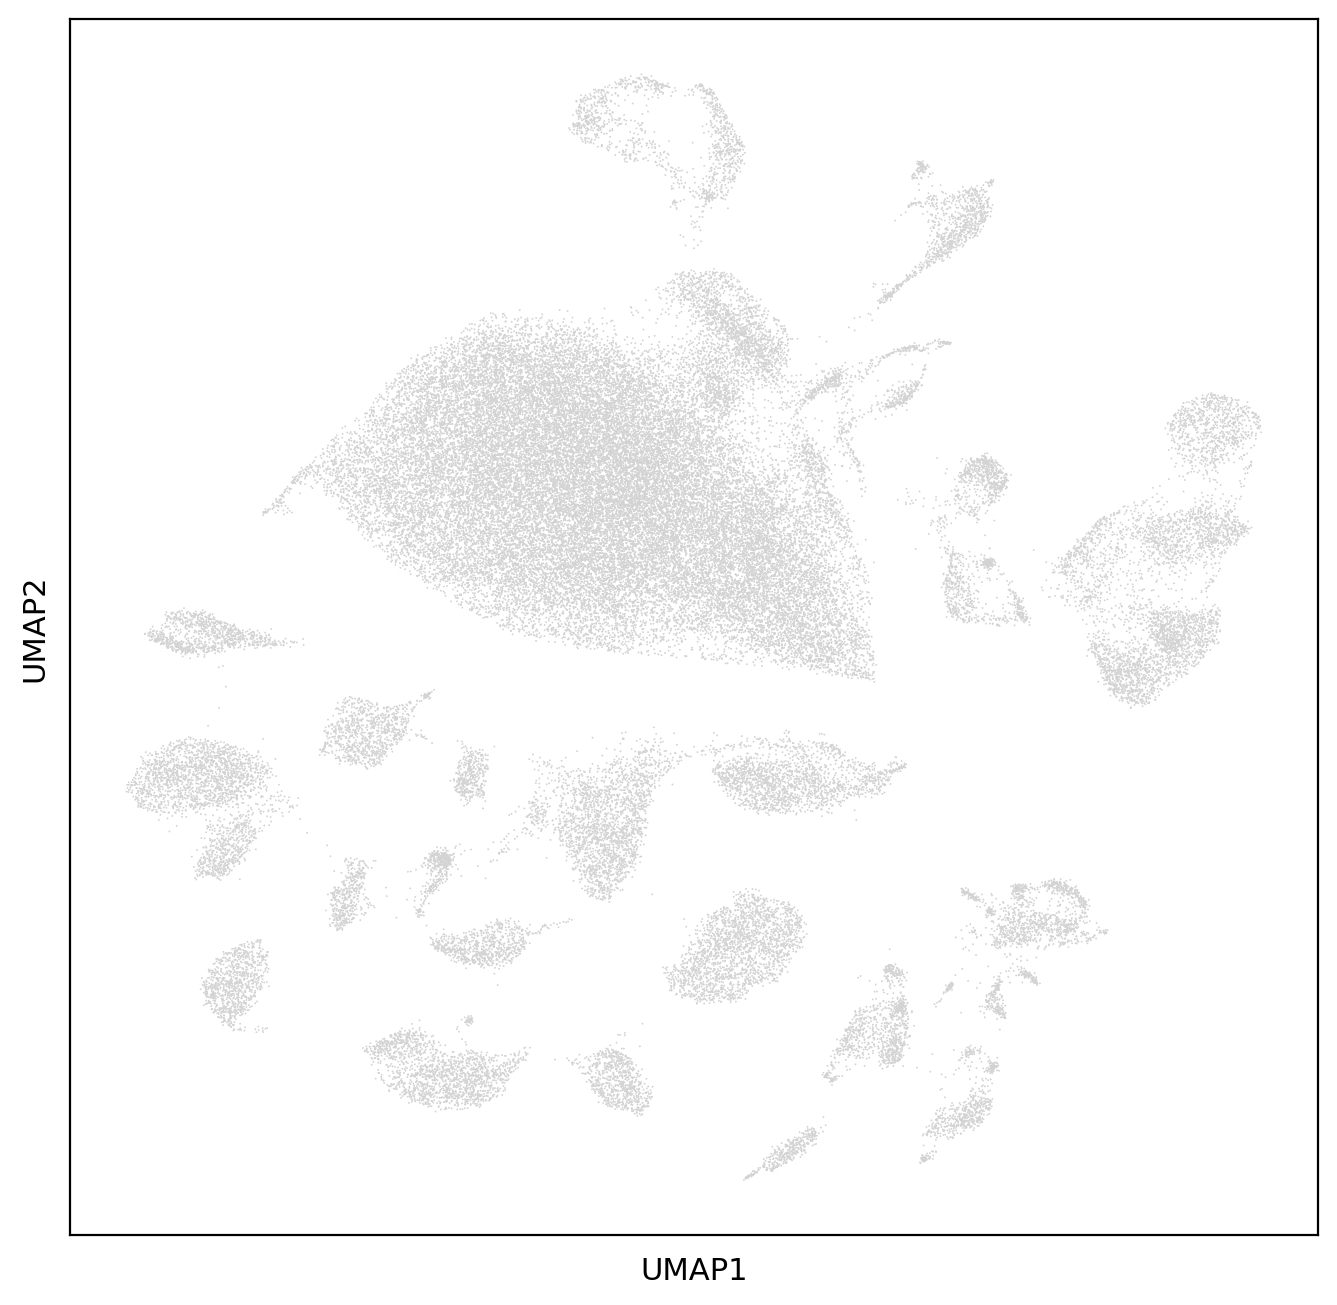

neighbors的数值为：40


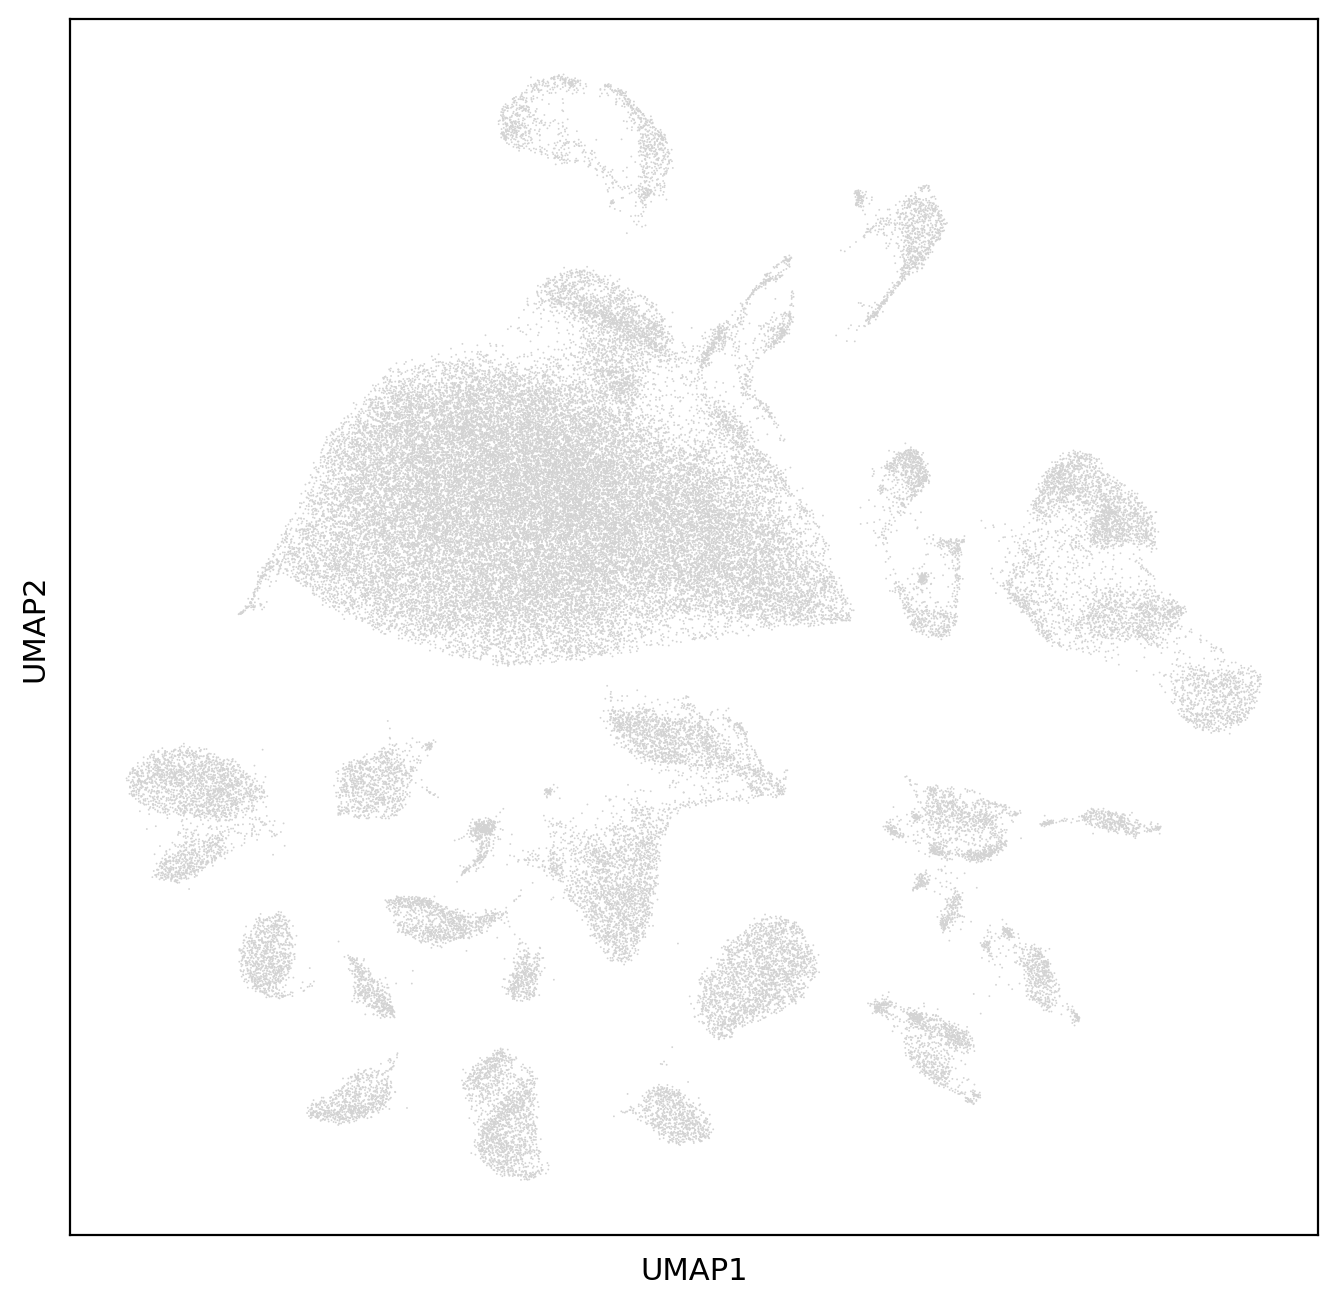

neighbors的数值为：45


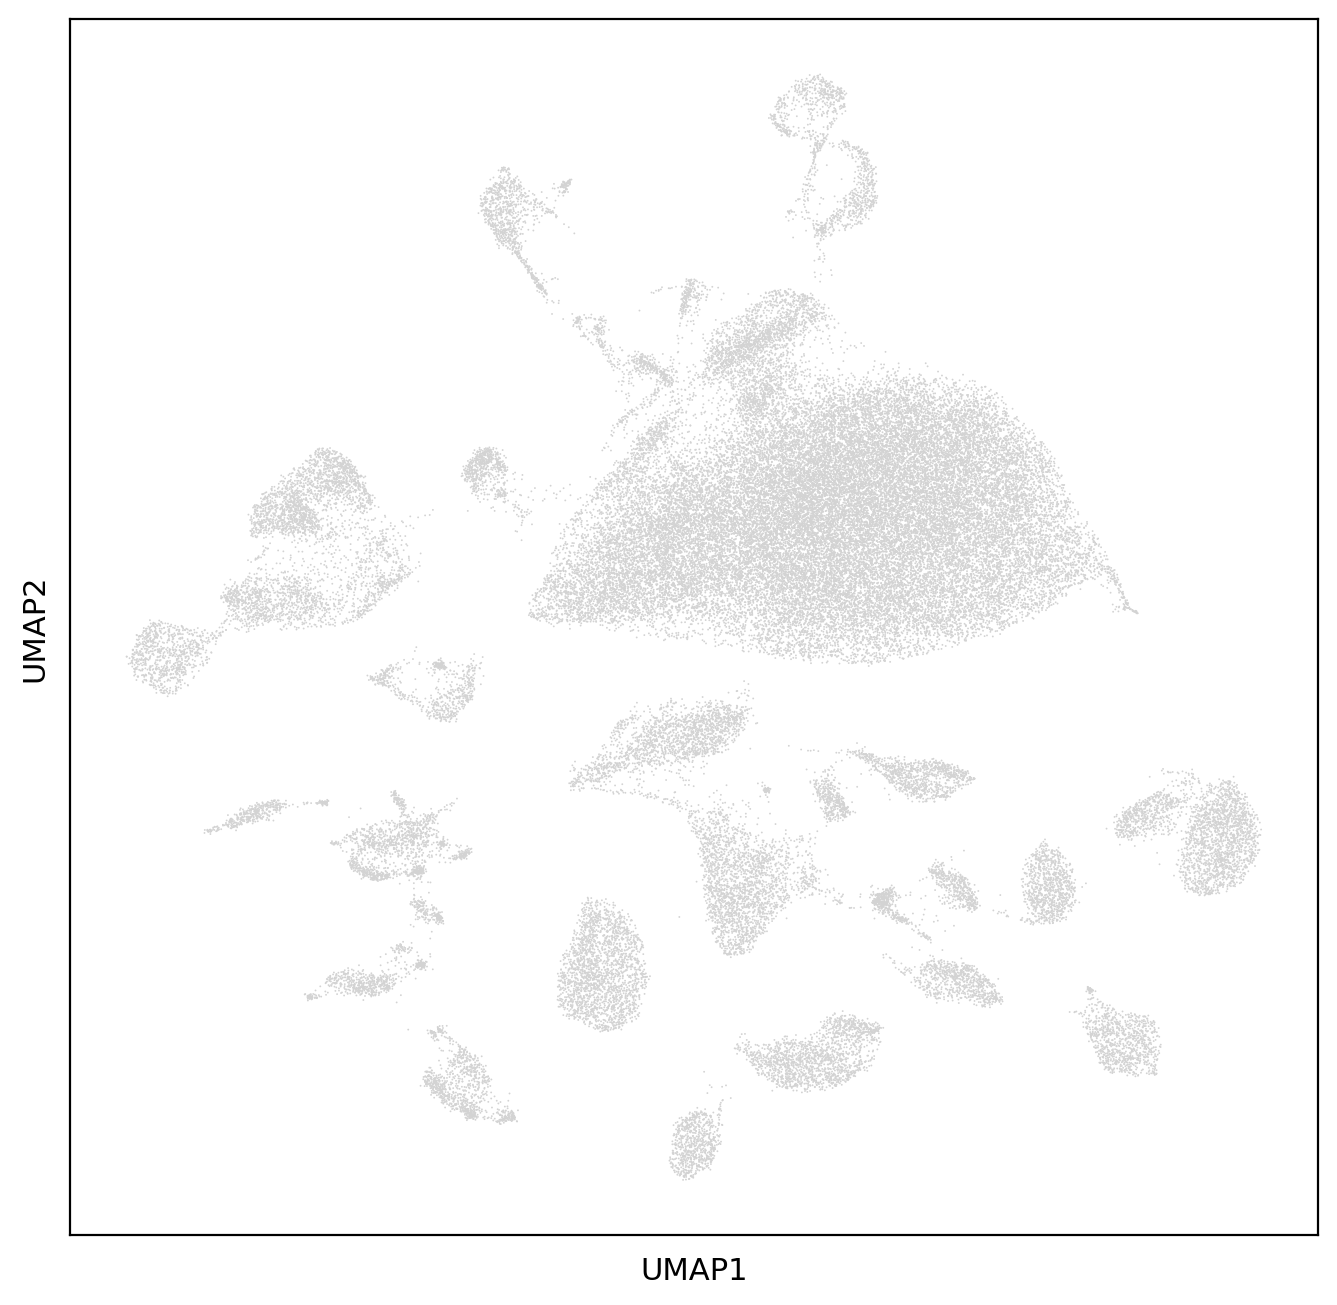

neighbors的数值为：50


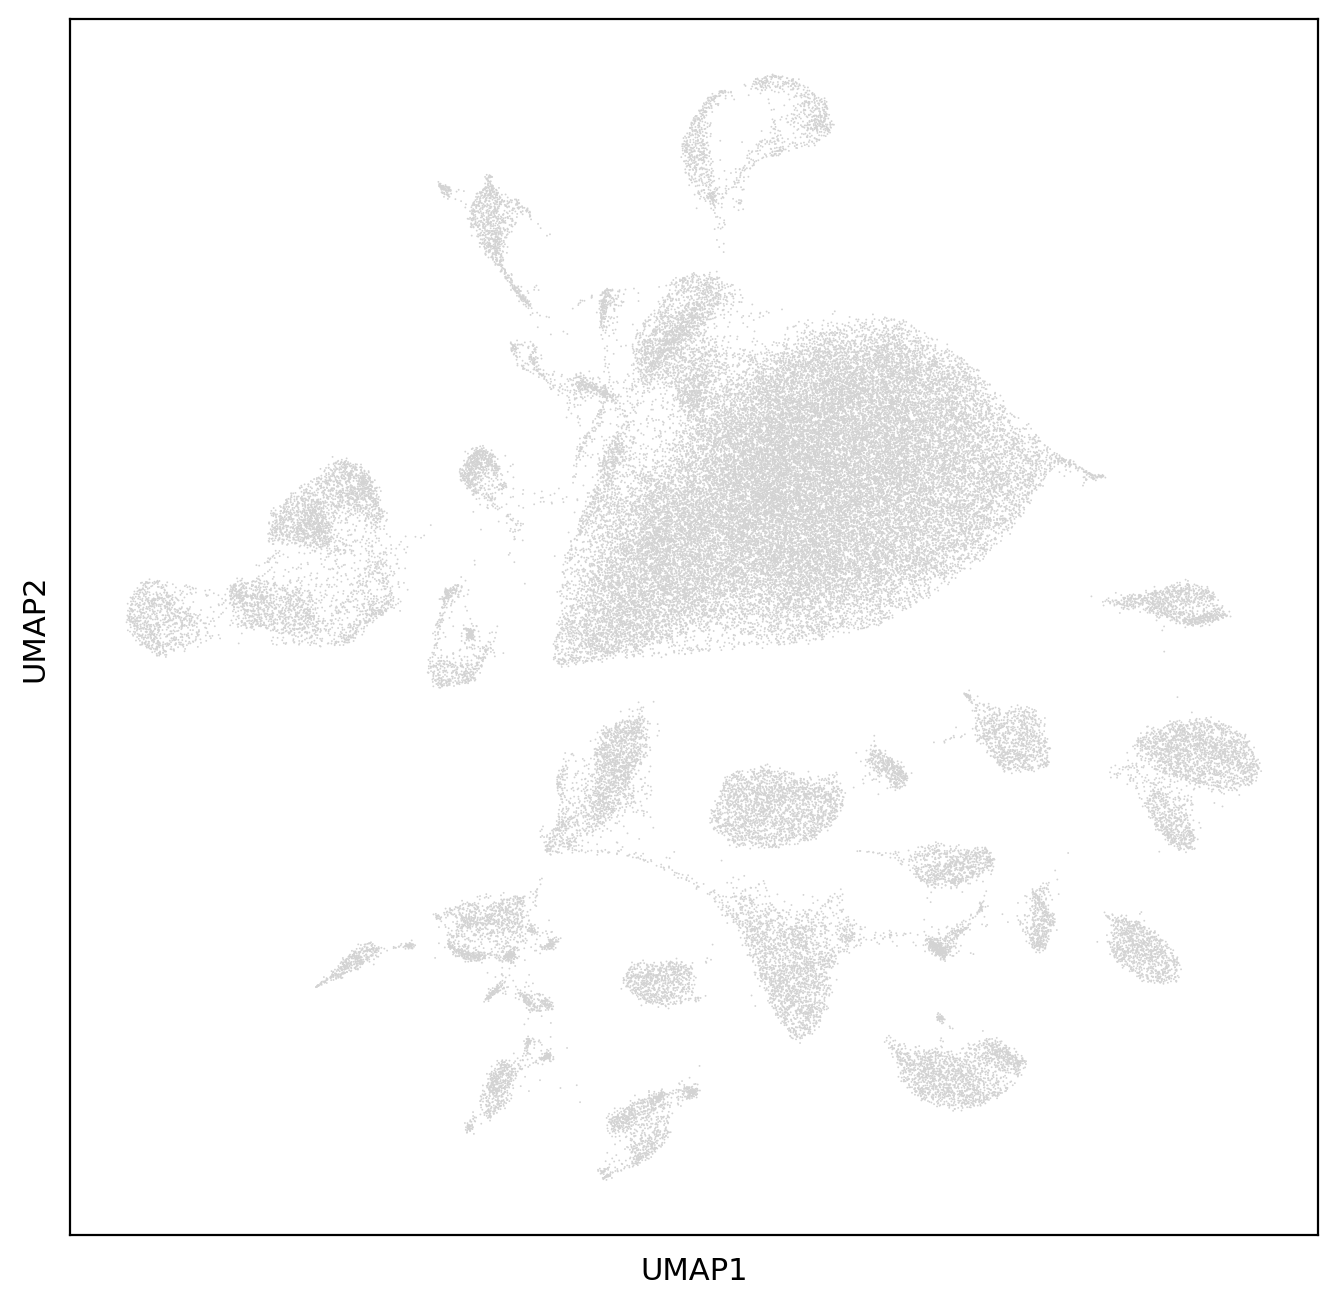

neighbors的数值为：55


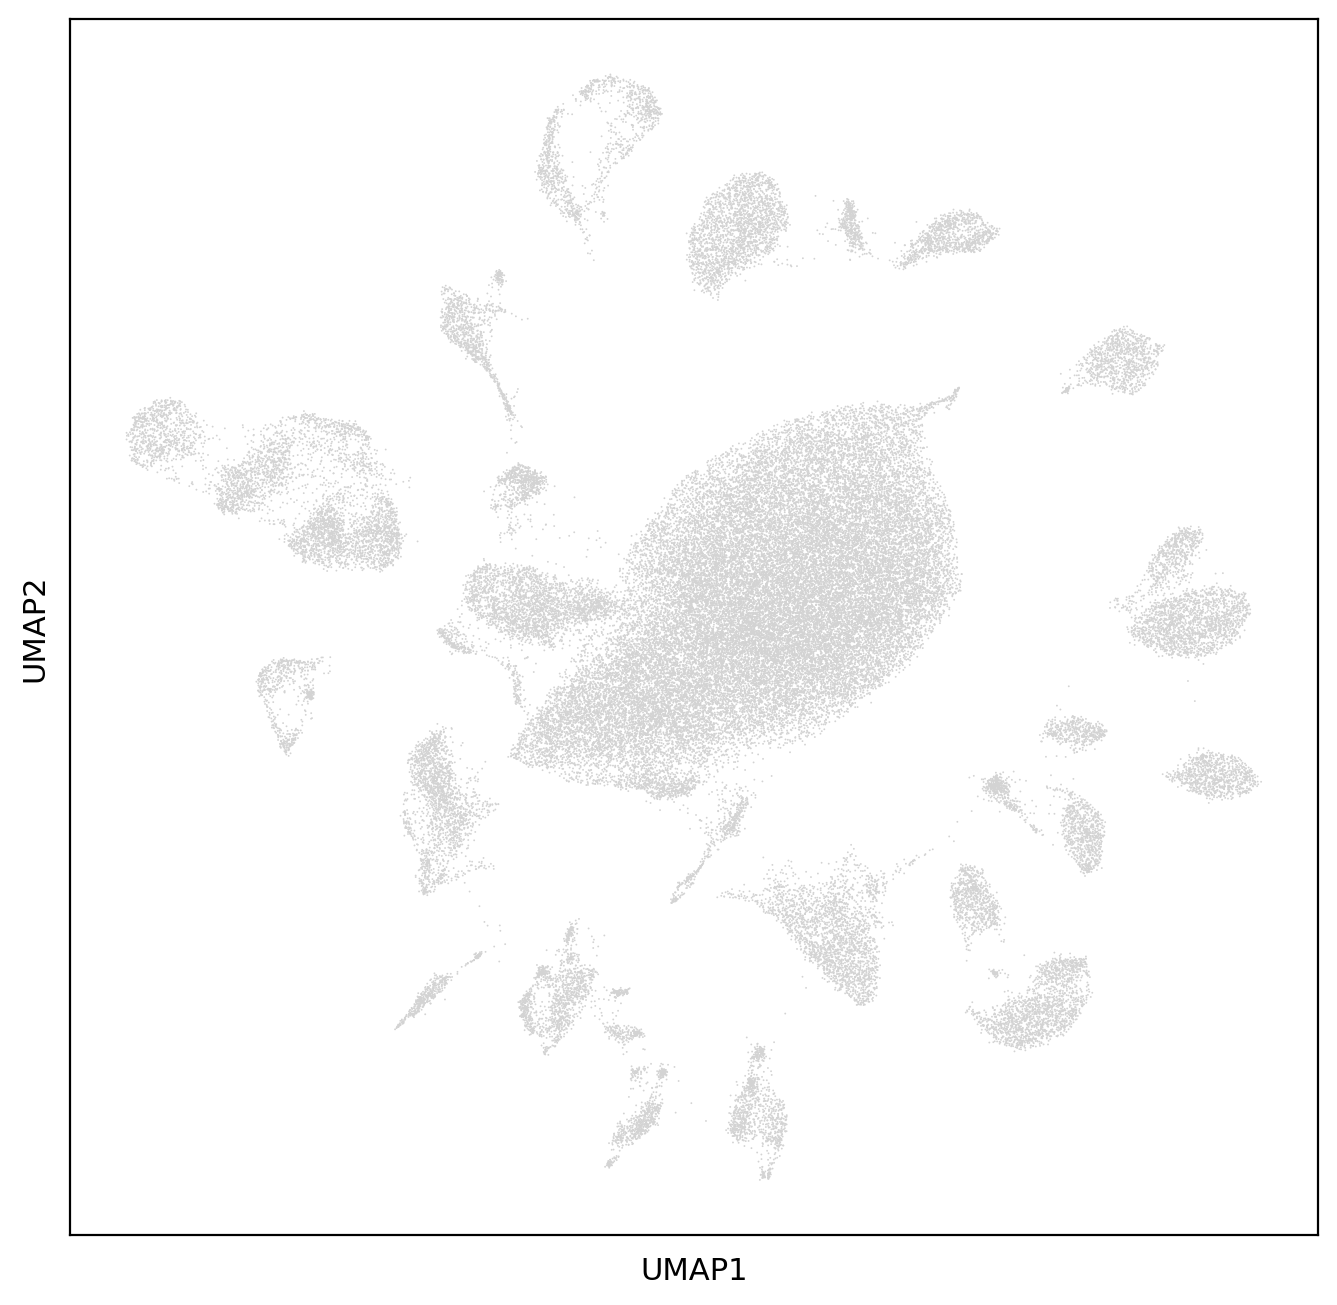

In [28]:
for i in range(10,60,5):
    sc.pp.neighbors(adata,n_pcs=20, n_neighbors= i,use_rep='X_pca_harmony')
    sc.tl.umap(adata)
    print(f'neighbors的数值为：{i}')
    sc.pl.umap(adata)